# CSI 5140 Assignment 4

## Samantha Bracellari

Before we begin, let's take a look at a few images from the Fashion-MNIST dataset.

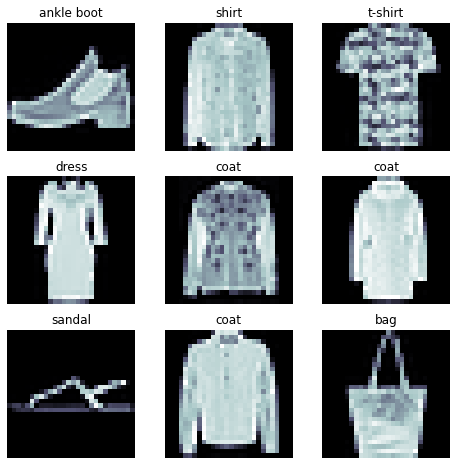

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

fashion = pd.read_csv('./fashion-mnist_train.csv')
X = fashion.drop('label', axis=1)
y = fashion['label']
X = X.to_numpy()

classes = [
    't-shirt', 'trouser', 'pullover', 'dress', 'coat', 
    'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot'
]

figure = plt.figure(figsize=(8, 8))
for i in range(1, 10):
    figure.add_subplot(3, 3, i)
    plt.title(classes[y[i]])
    plt.axis('off')
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.bone)

### Part 1 — PCA on Fashion-MNIST

First, perform PCA on the Fashion-MNIST data and visualize the first 8 eigen images resulting from the PCA.

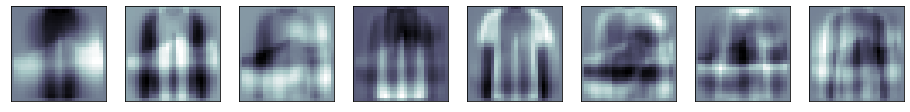

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing, decomposition

fashion = pd.read_csv('./fashion-mnist_train.csv')
X = fashion.drop('label', axis=1)
X = X.to_numpy()
X = preprocessing.normalize(X) # normalize data, needed to improve loss

pca = decomposition.PCA(n_components=8)
x_pca = pca.fit_transform(X)

fig = plt.figure(figsize=(16, 6))
for i in range(8):
    ax = fig.add_subplot(1, 8, i+1, xticks=[], yticks=[])
    ax.imshow(pca.components_[i].reshape(28, 28), cmap=plt.cm.bone)

Next, generate 10 reconstructed images, one for each class. This is done using the top 8 eigenvalues/eigenvectors. Calculate the error between the original and the reconstructed images.

In [4]:
import numpy as np

# grab indices of each class
y = np.array(y)
indices = []
for i in range(10):
    indices.append(np.where(y==i)[0][0])

loss: 0.17144482607517988


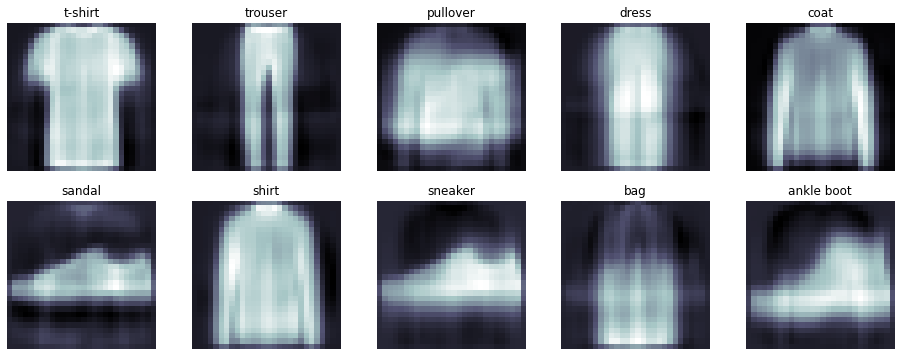

In [5]:
import numpy as np
import matplotlib.pyplot as plt

inv = pca.inverse_transform(x_pca) # reconstruct the image

figure = plt.figure(figsize=(16, 6))
for i in indices:
    figure.add_subplot(2, 5, indices.index(i)+1)
    plt.title(classes[y[i]])
    plt.axis('off')
    plt.imshow(inv[i].reshape(28, 28), cmap=plt.cm.bone)

loss = np.sum((X - inv) ** 2, axis=1).mean() # MSE
print('loss:', loss)

### Part 2 — t-SNE on Fashion-MNIST

Using t-SNE, visualize the Fashion-MNIST data in the original space.

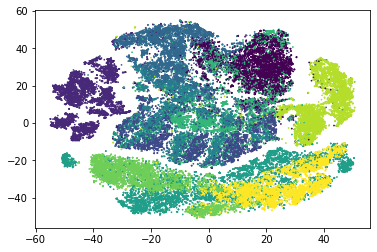

In [37]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

y = fashion.iloc[:, :1].to_numpy()
tsne = TSNE(n_components=2)
x_tsne = tsne.fit_transform(X)

plt.scatter(x_tsne[:,0], x_tsne[:,1], c = y, s = 0.5)

Next, visualize the data in the PCA space consisting of the top 8 eigen images.

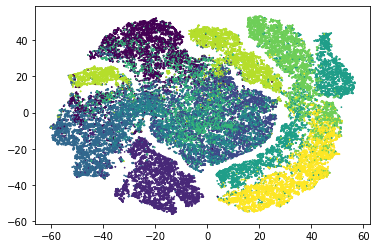

In [38]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne_pca = TSNE(n_components=2)
x_tsne_pca = tsne_pca.fit_transform(x_pca)

plt.scatter(x_tsne_pca[:,0], x_tsne_pca[:,1], c = y, s = 0.5)

### Part 3 — Linear Encoder with PCA and t-SNE

Implement a simple linear encoder with one hidden layer of 8 neurons and compare the reconstructed images with those done using PCA. Provide comments on your results.

In [6]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),             # load data as pytorch tensors
    transforms.Normalize((0.5), (0.5)) # normalize/scale the images
])

# download the data from MNIST & transform it
train_data = datasets.FashionMNIST('data', train=True, download=True, transform=transform)
test_data  = datasets.FashionMNIST('data', train=False, download=True, transform=transform)

# wrap the data in a pytorch dataloader object
trainloader = DataLoader(train_data, batch_size=15, shuffle=True)
testloader  = DataLoader(test_data, batch_size=15, shuffle=True)

In [7]:
##### model #####

import torch
import torch.nn as nn
import torch.nn.functional as F 

# architecture 
num_features, num_hidden = 784, 8

class Autoencoder(nn.Module):
    def __init__(self, num_features):
        super(Autoencoder, self).__init__()

        # encoder
        self.linear_1 = nn.Linear(num_features, num_hidden)
        self.linear_1.weight.data.normal_(0.0, 0.1)
        self.linear_1.bias.data.zero_()

        # decoder
        self.linear_2 = nn.Linear(num_hidden, num_features)
        self.linear_1.weight.data.normal_(0.0, 0.1)
        self.linear_1.bias.data.zero_()
    
    def forward(self, x):
        # encoder
        encoded = self.linear_1(x)

        # decoder
        decoded = self.linear_2(encoded)

        return decoded

torch.manual_seed(123)
model = Autoencoder(num_features=num_features)

In [9]:
import torch
import torch.nn as nn
from torch.autograd import Variable

# hyperparameters
num_epochs, lr, batch_size = 5, 0.005, 128

cost_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

for epoch in range(num_epochs):
    for batch_idx, (features, targets) in enumerate(trainloader):
        features = Variable(features.view(-1, 28*28))

        decoded = model(features)
        cost = cost_fn(decoded, features)
        optimizer.zero_grad()

        cost.backward()
        optimizer.step()

        if not batch_idx % 10000:
            print(
                'epoch: %03d/%03d | cost: %.4f' % (epoch+1, num_epochs, cost.item())
            )
print('training complete')

epoch: 001/005 | cost: 2.6396
epoch: 002/005 | cost: 0.1072
epoch: 003/005 | cost: 0.0881
epoch: 004/005 | cost: 0.0996
epoch: 005/005 | cost: 0.0930
training complete


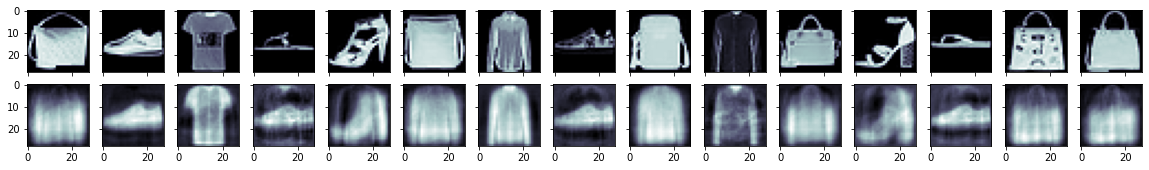

In [15]:
import matplotlib.pyplot as plt

n_images = 15

fix, axes = plt.subplots(nrows=2, ncols=n_images, sharex=True, sharey=True, figsize=(20, 2.5))
orig_images = features.data.numpy()[:n_images]
decoded_images = decoded.data.numpy()[:n_images]

for i in range(n_images):
    for ax, img in zip(axes, [orig_images, decoded_images]):
        ax[i].imshow(img[i].reshape((28, 28)), cmap=plt.cm.bone)

The image reconstruction was not bad with the linear encoder. Images are pretty fuzzy, but I'm still able to identify them. Perhaps increasing the number of neurons in the hidden layer will help, but I suspect that a linear encoder is too simple and does not generalize to data well.

Next, visualize the input weight matrix again in the form of 8 images. Compare these with 8 PCA based eigen images and give your comments.

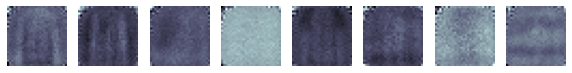

In [16]:
import numpy as np
import matplotlib.pyplot as plt

weights = model.linear_1.weight

fig, axs = plt.subplots(nrows=1, ncols=8, figsize=(10, 10))
for i in range(8):
    img = weights[i].detach().cpu().numpy().reshape(28, 28)
    axs[i].axis("off")
    axs[i].imshow(img, cmap=plt.cm.bone)

The hidden layer is very fuzzy. You can see some of the images a small bit, but the images are almost not recognizable.

Finally, using t-SNE, visualize the Fashion-MNIST data in the autoencoder's hidden space.

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


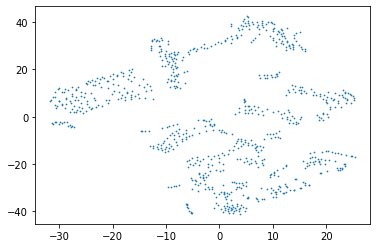

In [10]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

hidden = model.linear_2.weight
hidden = hidden.detach().cpu().numpy()

tsne_encoder = TSNE(n_components=2)
hidden_tsne_encoder = tsne_encoder.fit_transform(hidden)

plt.scatter(hidden_tsne_encoder[:,0], hidden_tsne_encoder[:,1], s = 0.5)

### Part 4 — Nonlinear Encoder with PCA and t-SNE

Repeat the linear encoder steps with a nonlinear encoder. First, we provide the code for the nonlinear encoder.

In [11]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),             # load data as pytorch tensors
    transforms.Normalize((0.5), (0.5)) # normalize/scale the images
])

# download the data from MNIST & transform it
train_data = datasets.FashionMNIST('data', train=True, download=True, transform=transform)
test_data  = datasets.FashionMNIST('data', train=False, download=True, transform=transform)

# wrap the data in a pytorch dataloader object
trainloader = DataLoader(train_data, batch_size=15, shuffle=True)
testloader  = DataLoader(test_data, batch_size=15, shuffle=True)

In [12]:
##### model #####

import torch
import torch.nn as nn
import torch.nn.functional as F 

# architecture 
num_features, num_hidden = 784, 8

class Autoencoder(nn.Module):
    def __init__(self, num_features):
        super(Autoencoder, self).__init__()

        # encoder
        self.linear_1 = nn.Linear(num_features, num_hidden)

        # decoder
        self.linear_2 = nn.Linear(num_hidden, num_features)
        self.linear_1.weight.data.normal_(0.0, 0.1)
        self.linear_1.bias.data.zero_()
    
    def forward(self, x):
        # encoder
        encoded = self.linear_1(x)
        encoded = F.leaky_relu(encoded)

        # decoder
        logits = self.linear_2(encoded)
        decoded = torch.sigmoid(logits)

        return decoded

torch.manual_seed(123)
model = Autoencoder(num_features=num_features)

In [13]:
import torch
import torch.nn as nn
from torch.autograd import Variable

# hyperparameters
num_epochs, lr, batch_size = 5, 0.005, 128

cost_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

for epoch in range(num_epochs):
    for batch_idx, (features, targets) in enumerate(trainloader):
        features = Variable(features.view(-1, 28*28))

        decoded = model(features)
        cost = cost_fn(decoded, features)
        optimizer.zero_grad()

        cost.backward()
        optimizer.step()

        if not batch_idx % 10000:
            print(
                'epoch: %03d/%03d | cost: %.4f' % (epoch+1, num_epochs, cost.item())
            )
print('training complete')

epoch: 001/005 | cost: 1.5082
epoch: 002/005 | cost: 0.6262
epoch: 003/005 | cost: 0.6206
epoch: 004/005 | cost: 0.5419
epoch: 005/005 | cost: 0.6533
training complete


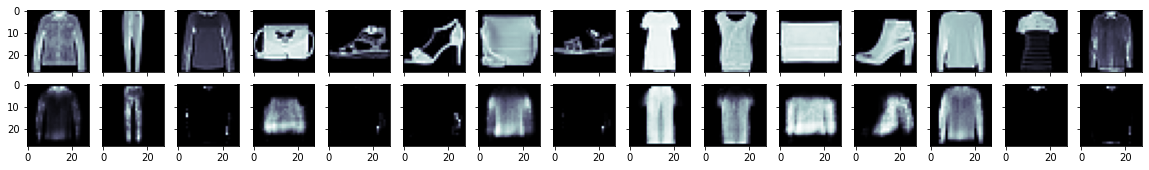

In [12]:
import matplotlib.pyplot as plt

n_images = 15

fix, axes = plt.subplots(nrows=2, ncols=n_images, sharex=True, sharey=True, figsize=(20, 2.5))
orig_images = features.data.numpy()[:n_images]
decoded_images = decoded.data.numpy()[:n_images]

for i in range(n_images):
    for ax, img in zip(axes, [orig_images, decoded_images]):
        ax[i].imshow(img[i].reshape((28, 28)), cmap=plt.cm.bone)

The image reconstruction with the nonlinear encoder was interesting. For some images, it struggled a lot with the reconstruction. In the images that it was able to reconstruct, however, the images are a lot clearer than they were in the linear encoder. PCA still outperforms.

Next, we visualize the input weight matrix again in the form of 8 images and compare with PCA.

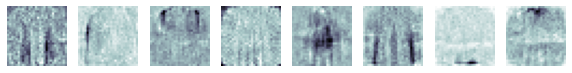

In [13]:
import numpy as np
import matplotlib.pyplot as plt

weights = model.linear_1.weight

fig, axs = plt.subplots(nrows=1, ncols=8, figsize=(10, 10))
for i in range(8):
    img = weights[i].detach().cpu().numpy().reshape(28, 28)
    axs[i].axis("off")
    axs[i].imshow(img, cmap=plt.cm.bone)

The weights here still somewhat resemble our original images. They are more recognizable than they were in the linear encoder, but still not amazing.

Finally, we use t-SNE to visualize the Fashion-MNIST data in the autoencoder's hidden space.

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


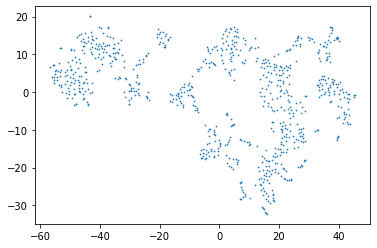

In [14]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

hidden = model.linear_2.weight
hidden = hidden.detach().cpu().numpy()

tsne_encoder = TSNE(n_components=2)
hidden_tsne_encoder = tsne_encoder.fit_transform(hidden)

plt.scatter(hidden_tsne_encoder[:,0], hidden_tsne_encoder[:,1], s = 0.5)

### Part 5 — K-Means Clustering on Fashion-MNIST

Perform k-means clustering on the Fashion-MNIST data. Vary the number of clusters from 8 to 12 and plot the SSE (clustering error) against the number of clusters.

In [22]:
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

train = pd.read_csv('./fashion-mnist_train.csv')
test = pd.read_csv('./fashion-mnist_test.csv')

X_train, X_test = train.drop('label', axis=1), test.drop('label', axis=1)
y_train, y_test = train['label'], test['label']
error, kvals = [], [8, 9, 10, 11, 12]

for k in kvals:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    error.append(np.mean(y_pred != y_test))

plt.figure(figsize=(12, 6))
plt.plot(kvals, error, color='black', linestyle='dotted', marker='o',
         markerfacecolor='green', markeredgecolor='green', markersize=15)
plt.title('number of clusters vs error')
plt.xlabel('k value')
plt.ylabel('error')